In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import cv2,os,glob

In [0]:
train_records = glob.glob('/content/drive/My Drive/Opacity-Detection-Data/TFRecords/Train/*.tfrecord')
train_records1 = glob.glob('/content/drive/My Drive/Opacity-Detection-Data/TFRecords/*.tfrecord')
val_records = glob.glob('/content/drive/My Drive/Opacity-Detection-Data/TFRecords/Test/*.tfrecord')
print(len(train_records),len(val_records))

train_dataset = tf.data.TFRecordDataset(train_records,num_parallel_reads=20)
val_dataset = tf.data.TFRecordDataset(val_records,num_parallel_reads=5)
train_dataset1 = tf.data.TFRecordDataset(train_records1,num_parallel_reads=20)

image_feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
}

float_image_feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.float32),
}


def _parse_image_function(example_proto):
  features = tf.io.parse_single_example(example_proto, image_feature_description)
  #image_raw = tf.image.decode_jpeg(features['image_raw'],channels=1)
  image_raw = tf.image.decode_jpeg(features['image_raw'],channels=3)
  # image_raw = tf.image.random_brightness(image_raw,max_delta=0.3)
  # image_raw = tf.image.random_contrast(image_raw,lower=0.2,upper=1.2)
  image_raw = tf.cast(image_raw , tf.float32) * (1. / 255)
  #image_raw = tf.image.resize(image_raw,(400,400))
  image_raw = tf.image.resize(image_raw,(200,200))
  label = tf.reshape(features['label'],shape=(1,))

  return image_raw,label

def _parse_val_image_function(example_proto):
  features = tf.io.parse_single_example(example_proto, image_feature_description)
  #image_raw = tf.image.decode_jpeg(features['image_raw'],channels=1)
  image_raw = tf.image.decode_jpeg(features['image_raw'],channels=3)
  image_raw = tf.cast(image_raw , tf.float32) * (1. / 255)
  #image_raw = tf.image.resize(image_raw,(400,400))
  image_raw = tf.image.resize(image_raw,(200,200))
  label = tf.reshape(features['label'],shape=(1,))

  return image_raw,label  

def float_parse_image_function(example_proto):
  features = tf.io.parse_single_example(example_proto, float_image_feature_description)
  #image_raw = tf.image.decode_jpeg(features['image_raw'],channels=1)
  image_raw = tf.image.decode_jpeg(features['image_raw'],channels=3)
  # image_raw = tf.image.random_brightness(image_raw,max_delta=0.3)
  # image_raw = tf.image.random_contrast(image_raw,lower=0.2,upper=1.2)
  image_raw = tf.cast(image_raw , tf.float32) * (1. / 255)
  #image_raw = tf.image.resize(image_raw,(400,400))
  image_raw = tf.image.resize(image_raw,(200,200))
  label = tf.cast(tf.reshape(features['label'],shape=(1,)),tf.int64)

  return image_raw,label


train_dataset = train_dataset.map(_parse_image_function)
val_dataset = val_dataset.map(_parse_val_image_function)
train_dataset1 = train_dataset1.map(float_parse_image_function)

train_dataset,val_dataset,train_dataset1

12 3


(<MapDataset shapes: ((200, 200, 3), (1,)), types: (tf.float32, tf.int64)>,
 <MapDataset shapes: ((200, 200, 3), (1,)), types: (tf.float32, tf.int64)>,
 <MapDataset shapes: ((200, 200, 3), (1,)), types: (tf.float32, tf.int64)>)

In [0]:
train_dataset = train_dataset.concatenate(train_dataset1)
train_dataset

<ConcatenateDataset shapes: ((200, 200, 3), (1,)), types: (tf.float32, tf.int64)>

In [0]:
TRAIN_BATCH = 8
VAL_BATCH = 16

train_dataset = train_dataset.shuffle(21000).batch(TRAIN_BATCH).prefetch(8)
val_dataset = val_dataset.shuffle(1000).batch(VAL_BATCH)
train_dataset,val_dataset

(<PrefetchDataset shapes: ((None, 200, 200, 3), (None, 1)), types: (tf.float32, tf.int64)>,
 <BatchDataset shapes: ((None, 200, 200, 3), (None, 1)), types: (tf.float32, tf.int64)>)

CUSTOM Model

In [0]:
from tensorflow.keras.layers import Conv2D,GlobalMaxPooling2D,Dense,Dropout,BatchNormalization,MaxPool2D,DepthwiseConv2D,Flatten,AveragePooling2D,SeparableConv2D
def create_model(shape=(400,400,1)):

  x,y,y1,z = 64,64,64,64

  input_layer = tf.keras.layers.Input(shape=shape)

  conv1 = SeparableConv2D(x,(3,3),activation='relu')(input_layer)
  mp1 = MaxPool2D(pool_size=(4,4))(conv1)

  mp1_ = MaxPool2D(strides=(2,2))(input_layer)
  conv1_ = SeparableConv2D(x,(4,4),strides=(2,2),activation='relu')(mp1_)

  merge1 = tf.keras.layers.multiply([conv1_,mp1])
  bn1 = BatchNormalization()(merge1)

  conv2 = SeparableConv2D(y,(2,2),activation='relu')(bn1)
  mp2 = MaxPool2D(pool_size=(3,3))(conv2)

  mp2_ = MaxPool2D(pool_size=(3,3))(bn1)
  conv2_ = SeparableConv2D(y,(2,2),strides=(1,1),activation='relu')(mp2_)

  conv2__ = SeparableConv2D(y1,(2,2),strides=(3,3),activation='relu')(bn1)
  conv2__ = SeparableConv2D(y,(2,2),activation='relu')(conv2__)

  merge2 = tf.keras.layers.multiply([conv2_,mp2,conv2__])
  bn2 = BatchNormalization()(merge2)

  conv3 = SeparableConv2D(z,(2,2),activation='relu')(bn2)
  mp3 = MaxPool2D(pool_size=(2,2))(conv3)

  mp3_ = MaxPool2D((2,2))(bn2)
  conv3_ = SeparableConv2D(z,(2,2)) (mp3_)

  merge3 = tf.keras.layers.multiply([conv3_,mp3])
  bn3 = BatchNormalization()(merge3)

  layer_1 = Conv2D(128, (1,1), padding='same', activation='relu')(bn3)
  layer_1 = Conv2D(128, (3,3), padding='same', activation='relu')(layer_1)

  layer_2 = Conv2D(128, (1,1), padding='same', activation='relu')(bn3)
  layer_2 = Conv2D(128, (5,5), padding='same', activation='relu')(layer_2)

  layer_3 = MaxPool2D((3,3), strides=(1,1), padding='same')(bn3)
  layer_3 = Conv2D(128, (1,1), padding='same', activation='relu')(layer_3)

  mid_1 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)


  gmp = GlobalMaxPooling2D()(mid_1)

  dense = Dense(128,activation='relu')(gmp)
  # drop1 = Dropout(0.1)(dense)
  dense1 = Dense(32,activation='relu')(dense)
  dense2 = Dense(8,activation='relu')(dense1)
  dense3 = Dense(1,activation='sigmoid')(dense2)

  model = tf.keras.models.Model(inputs=input_layer,outputs=dense3)

  return model

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 1) 0                                            
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 200, 200, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 398, 398, 64) 137         input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 99, 99, 64)   144         max_pooling2d_1[0][0]            
___________________________________________________________________________________________

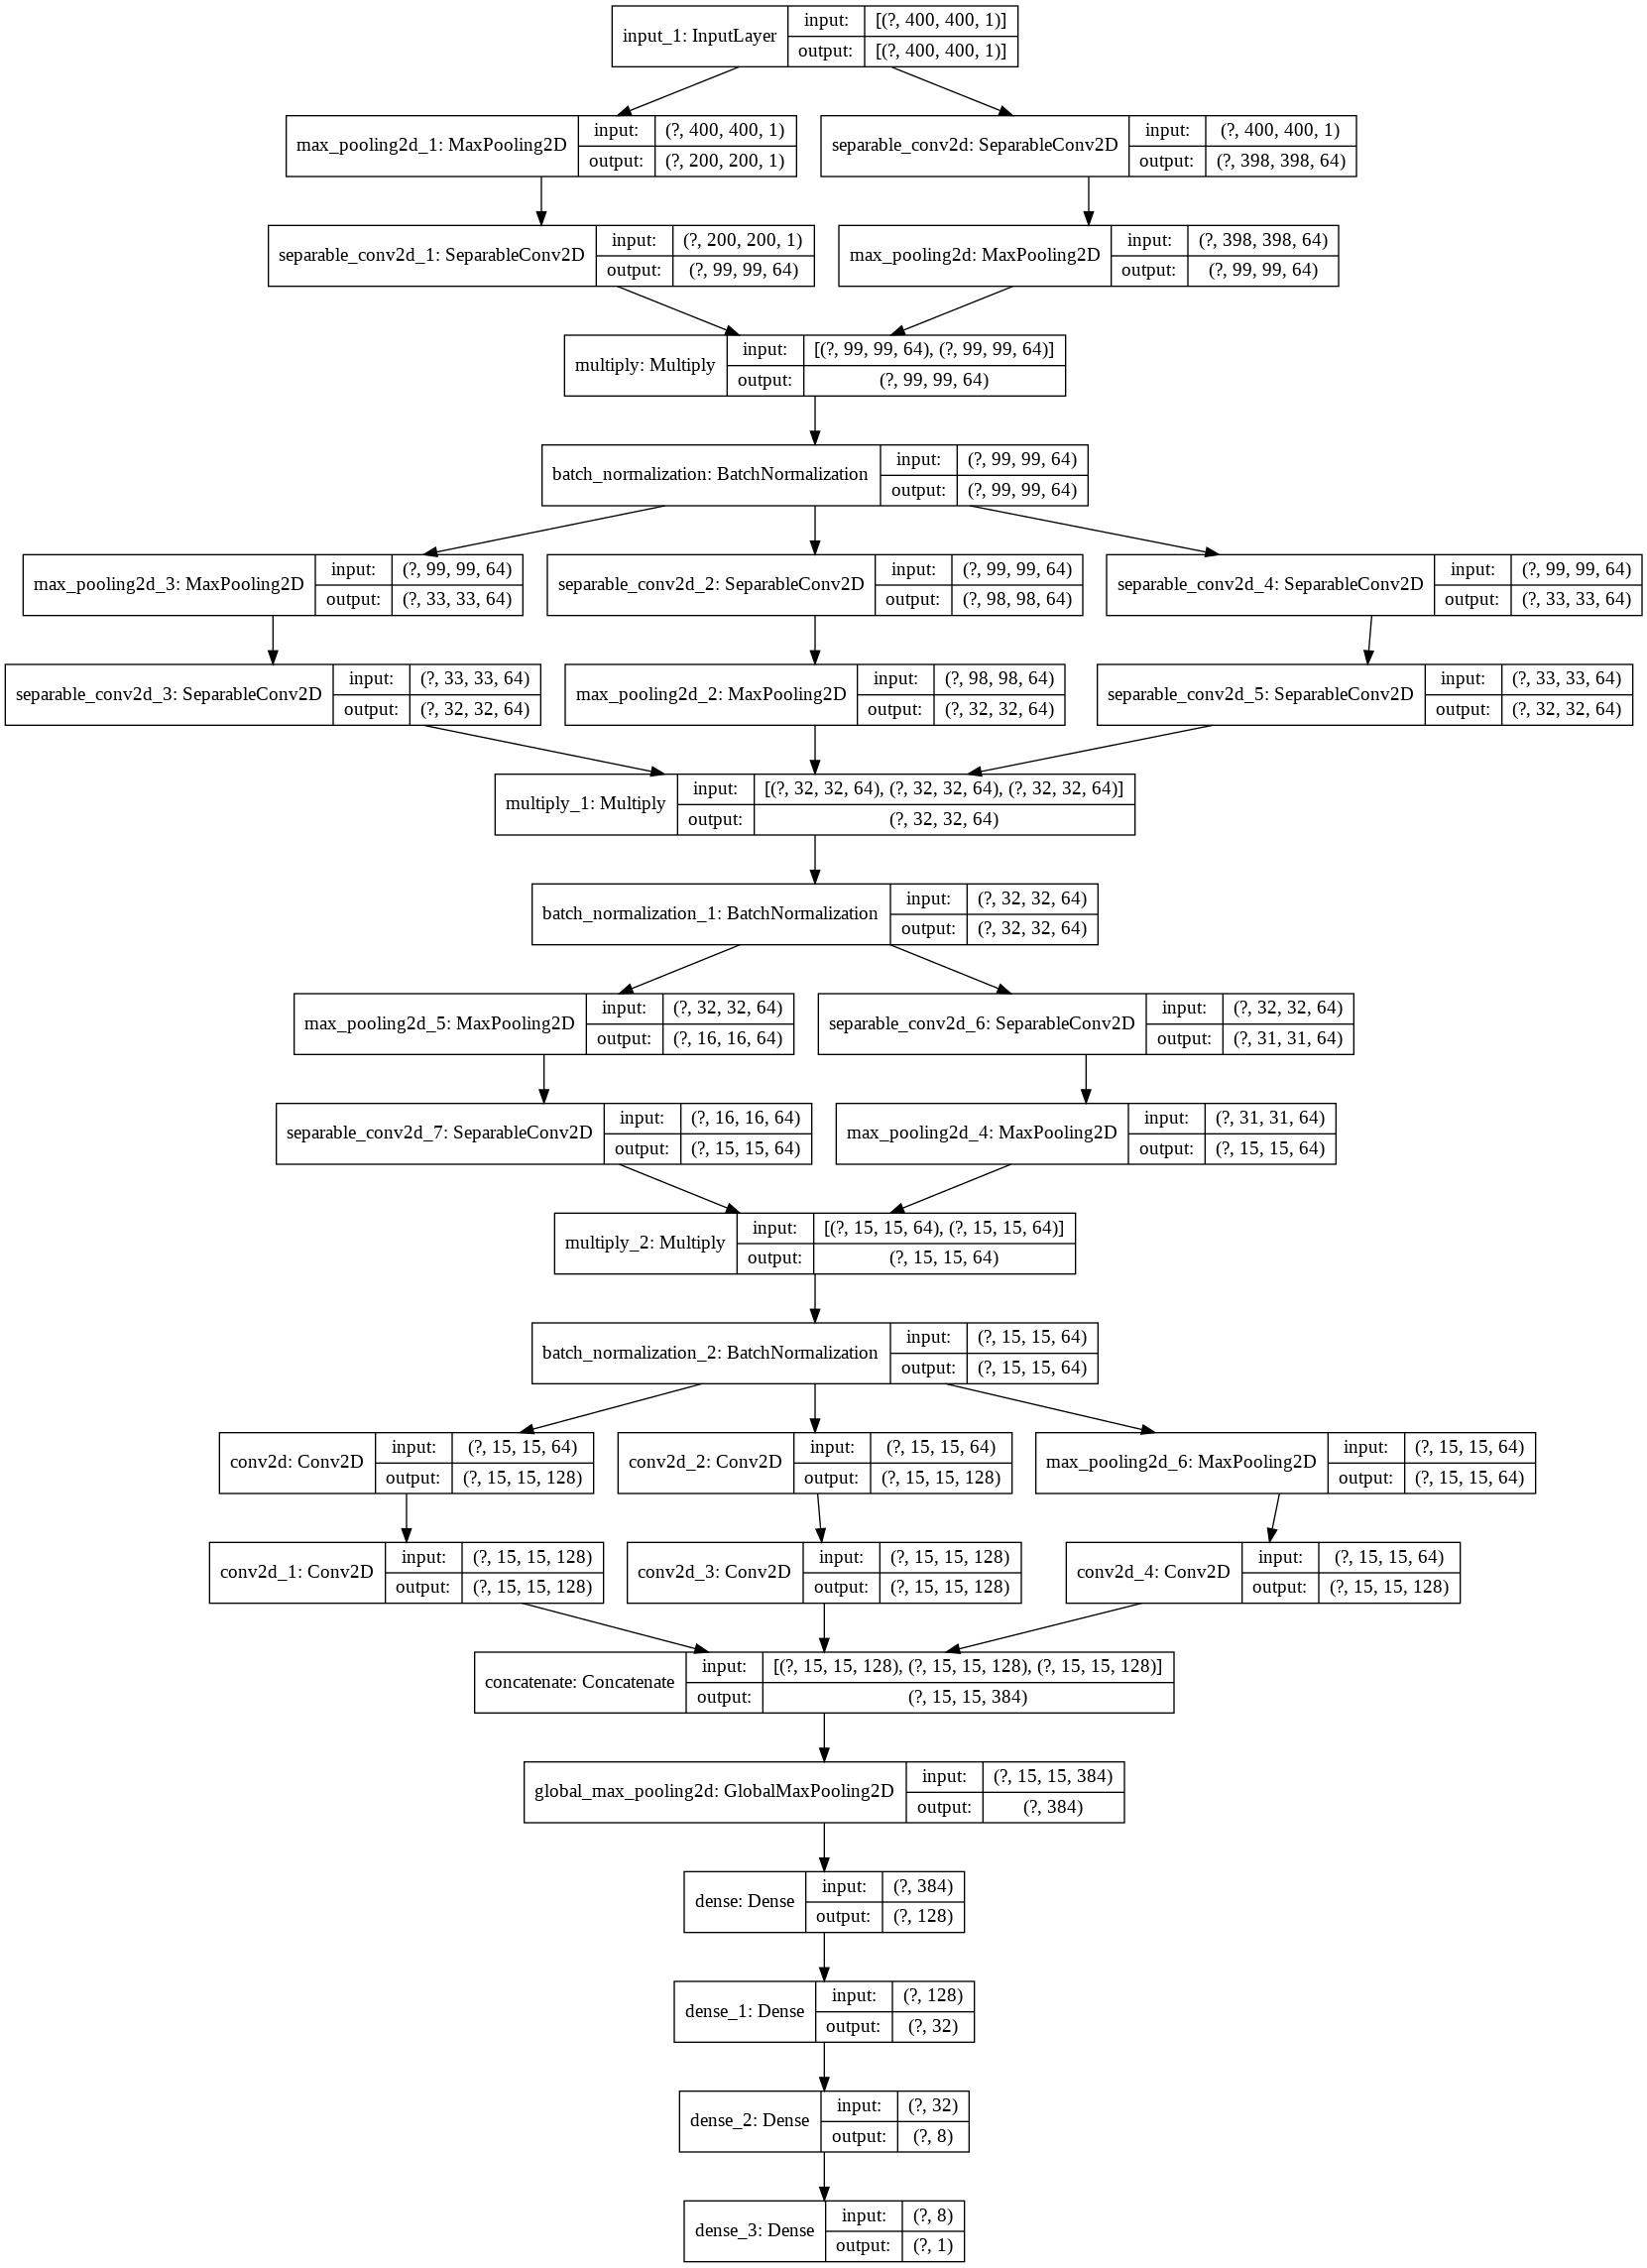

In [0]:
from tensorflow.keras.utils import plot_model
model = create_model()
model.summary()
plot_model(model,'Model.png',show_shapes=True)

In [0]:
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,weighted_metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('CheckpointChannel3.h5',save_best_only=True,verbose=1)
checkpoint_recall = tf.keras.callbacks.ModelCheckpoint('CheckpointRecall3.h5',monitor='val_recall',verbose=1,save_best_only=True,mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(patience=4,verbose=1)

In [0]:
tf.keras.backend.clear_session()

In [0]:
history = model.fit(train_dataset,validation_data=val_dataset,epochs=10,callbacks=[checkpoint,checkpoint_recall])

Epoch 1/10
   2663/Unknown - 139s 52ms/step - loss: 0.3022 - accuracy: 0.8804 - precision: 0.8649 - recall: 0.8603 - auc: 0.9430
Epoch 00001: val_loss improved from inf to 0.26858, saving model to CheckpointChannel1.h5

Epoch 00001: val_recall improved from -inf to 0.82389, saving model to CheckpointRecall1.h5
2664/2664 [==============================] - 146s 55ms/step - loss: 0.3021 - accuracy: 0.8804 - precision: 0.8649 - recall: 0.8603 - auc: 0.9430 - val_loss: 0.2686 - val_accuracy: 0.8901 - val_precision: 0.9622 - val_recall: 0.8239 - val_auc: 0.9640
Epoch 2/10
2663/2664 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8784 - precision: 0.8624 - recall: 0.8584 - auc: 0.9433
Epoch 00002: val_loss did not improve from 0.26858

Epoch 00002: val_recall did not improve from 0.82389
2664/2664 [==============================] - 143s 54ms/step - loss: 0.3022 - accuracy: 0.8784 - precision: 0.8624 - recall: 0.8584 - auc: 0.9434 - val_loss: 0.2718 - val_accuracy: 0.89

RESNET Model

In [0]:
resnet = tf.keras.applications.resnet.ResNet101(include_top=False, weights='imagenet',pooling='avg',input_shape=(200,200,3))

In [0]:
dense1 = tf.keras.layers.Dense(64,activation='relu')(resnet.output)
dense3 = tf.keras.layers.Dense(16,activation='relu')(dense1)
final_dense = tf.keras.layers.Dense(1,activation='sigmoid')(dense3)
model = tf.keras.models.Model(inputs=resnet.input,outputs=final_dense)

In [0]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy',optimizer=optimizer,weighted_metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('CheckpointChannel3.h5',save_best_only=True,verbose=1)
checkpoint_recall = tf.keras.callbacks.ModelCheckpoint('CheckpointRecall3.h5',monitor='val_recall',verbose=1,save_best_only=True,mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(patience=4,verbose=1)

In [0]:
tf.keras.backend.clear_session()

In [0]:
history = model.fit(train_dataset,validation_data=val_dataset,epochs=10,callbacks=[checkpoint,checkpoint_recall])

Epoch 1/10
   2664/Unknown - 1042s 391ms/step - loss: 0.4393 - accuracy: 0.8128 - precision: 0.7922 - recall: 0.7742 - auc: 0.8768
Epoch 00001: val_loss improved from inf to 0.69507, saving model to CheckpointChannel3.h5

Epoch 00001: val_recall improved from -inf to 0.98785, saving model to CheckpointRecall3.h5
2664/2664 [==============================] - 1064s 400ms/step - loss: 0.4393 - accuracy: 0.8128 - precision: 0.7922 - recall: 0.7742 - auc: 0.8768 - val_loss: 0.6951 - val_accuracy: 0.6169 - val_precision: 0.5803 - val_recall: 0.9879 - val_auc: 0.8469
Epoch 2/10
2664/2664 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.8622 - precision: 0.8398 - recall: 0.8457 - auc: 0.9225
Epoch 00002: val_loss improved from 0.69507 to 0.23485, saving model to CheckpointChannel3.h5

Epoch 00002: val_recall did not improve from 0.98785
2664/2664 [==============================] - 1060s 398ms/step - loss: 0.3482 - accuracy: 0.8622 - precision: 0.8398 - recall: 0.8457 - au

KeyboardInterrupt: ignored

In [0]:
model = tf.keras.models.load_model('/content/drive/My Drive/Opacity-Detection-Data/PrunedResnet.h5')

In [30]:
model.evaluate(val_dataset,verbose=1)

59/59 [==============================] - 3s 50ms/step - loss: 0.1610 - accuracy: 0.9381 - precision_3: 0.9486 - recall_3: 0.9332 - auc_3: 0.9845


[0.16103366017341614,
 0.9381003379821777,
 0.9485596418380737,
 0.9331983923912048,
 0.9845435619354248]

In [31]:
from collections import Counter
predictions = []
for i in glob.glob('/content/TestImages/*'):
  img = open(i,'rb').read()
  image = tf.image.decode_jpeg(img,channels=3)
  img = tf.cast(image,tf.float32) *(1./255)
  img = tf.image.resize(img,(200,200))
  img1 = tf.expand_dims(img,axis=0)
  pred = new_pruned_model.predict(img1)
  pred1 = "Negative" if pred[0]<0.3 else "Positive" # Reduced threshold because False Positives are better than False Negatives
  predictions.append(pred1)
  print(i,pred1,pred)
print(Counter(predictions))

/content/TestImages/person1021_virus_1711.jpeg Positive [[0.9431692]]
/content/TestImages/IM-0467-0001-0002.jpeg Negative [[0.00190825]]
/content/TestImages/person1023_virus_1714.jpeg Positive [[0.9937022]]
/content/TestImages/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-001-fig2b.png Positive [[0.697654]]
/content/TestImages/IM-0466-0001.jpeg Negative [[0.00252306]]
/content/TestImages/person1020_virus_1710.jpeg Positive [[0.37485564]]
/content/TestImages/person1022_bacteria_2953.jpeg Positive [[0.9669087]]
/content/TestImages/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-001-fig2a.png Negative [[0.2380773]]
/content/TestImages/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-003-fig4b.png Positive [[0.999765]]
/content/TestImages/person1020_bacteria_2951.jpeg Positive [[0.9929595]]
/content/TestImages/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-003-fig4a.png Positive [[0.9996068]]
/content/TestImages/person1022_virus_1712.jpeg Positive [[0.85816294]]
/content/TestImages/person102

VISUALISING GRADIENTS

In [0]:
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName

		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()

	def find_target_layer(self):
		for layer in reversed(self.model.layers):
			if len(layer.output_shape) == 4:
				return layer.name

		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

	def compute_heatmap(self, image, eps=1e-8):
		gradModel = tf.keras.models.Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output, 
				self.model.output])

		with tf.GradientTape() as tape:
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]
			
		grads = tape.gradient(loss, convOutputs)
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")
		return heatmap

	def overlay_heatmap(self, heatmap, image, alpha=0.5,colormap=cv2.COLORMAP_VIRIDIS):
		heatmap = cv2.applyColorMap(heatmap,colormap)
		image = np.squeeze(image)
		image = cv2.resize(image,(200,200))
		# image = cv2.resize(cv2.cvtColor(image,cv2.COLOR_GRAY2RGB),(400,400))
		output = cv2.addWeighted(image,0.5,heatmap,0.5,0)
		return (heatmap, output)

4-x-day1.jpg


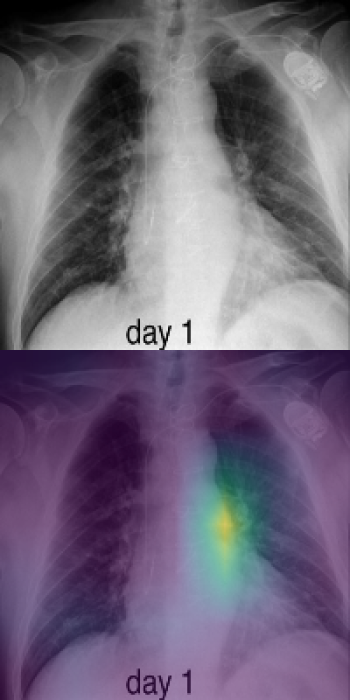

Positive [0.8556575] 
-----------------------------------------------------------------------------------
4-x-day8.jpg


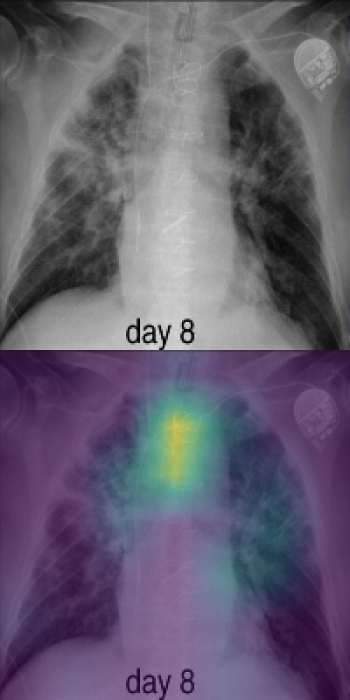

Positive [0.99226755] 
-----------------------------------------------------------------------------------
4-x-day13.jpg


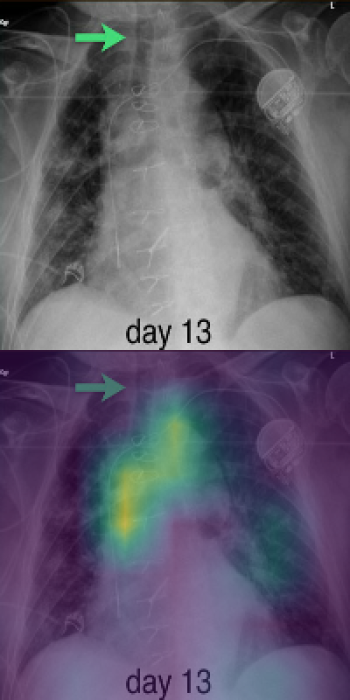

Positive [0.98235816] 
-----------------------------------------------------------------------------------
4-x-day4.jpg


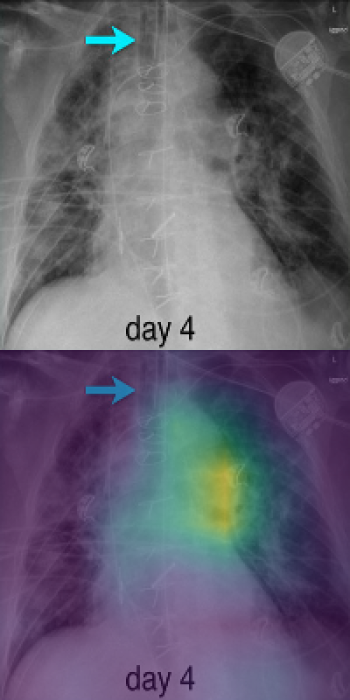

Positive [0.9996842] 
-----------------------------------------------------------------------------------


In [35]:
from google.colab.patches import cv2_imshow
from matplotlib.cm import viridis
import imutils

for i in reversed(model.layers):
        if len(i.output.shape)==4:
            visualising_layer = i.name
            break    

for i in glob.glob('/content/TestImages/*.jpg')[:10]:
  filename = i.split('/')[-1]
  if filename.split('.')[-1] == 'jfif':
    continue
  print(filename) 
 
  img = open(i,'rb').read()
  image = tf.image.decode_jpeg(img,channels=3)
  img = tf.cast(image,tf.float32) *(1./255)
  img = tf.image.resize(img,(200,200))
  img1 = tf.expand_dims(img,axis=0) 
  predi = model.predict(img1) 
  gc = GradCAM(model,0,layerName=visualising_layer)

  heatmap = gc.compute_heatmap(img1)
  heatmap = cv2.resize(heatmap,(200,200))

  (heatmap, output) = gc.overlay_heatmap(heatmap,image, alpha=0.5)
  image = cv2.resize(np.array(image),(200,200))
  #image = cv2.resize(cv2.cvtColor(np.array(image),cv2.COLOR_GRAY2RGB),(400,400))
  output = np.vstack([image, output])
  output = imutils.resize(output, height=700)
  cv2_imshow(output)
  # cv2.imwrite('/content/drive/My Drive/PredictionVisualisations/'+filename,output,pred)
  pred = "Negative" if predi[0]<0.35 else "Positive"
  print(pred,predi[0],"\n-----------------------------------------------------------------------------------")

In [0]:
model.save('/content/drive/My Drive/Opacity-Detection-Data/ResNetBestModel.h5')

MODEL PRUNING (For size reduction)

In [0]:
! pip install -q tensorflow-model-optimization
from tensorflow_model_optimization.sparsity import keras as sparsity
epochs = 4
end_step = np.ceil(1.0 * 2664).astype(np.int32) * epochs
print(end_step)

new_pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.9,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=100)
}

new_pruned_model = sparsity.prune_low_magnitude(model, **new_pruning_params)
new_pruned_model.summary()

new_pruned_model.compile(loss='binary_crossentropy',optimizer='adam',weighted_metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])

10656
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv1_pad ( (None, 206, 206, 3)  1           input_1[0][0]                    
__________________________________________________________________________________________________
prune_low_magnitude_conv1_conv  (None, 100, 100, 64) 18882       prune_low_magnitude_conv1_pad[0][
__________________________________________________________________________________________________
prune_low_magnitude_conv1_bn (P (None, 100, 100, 64) 257         prune_low_magnitude_conv1_conv[0]
_____________________________________________________________________________________

In [0]:
logdir = '/content/logdir_second_prune'
callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir=logdir, profile_batch=0)
]

new_pruned_model.fit(train_dataset,
          epochs=epochs,
          verbose=1,
          callbacks=callbacks,
          validation_data=val_dataset)

Epoch 1/4
2664/2664 [==============================] - 780s 293ms/step - loss: 0.1830 - accuracy: 0.9328 - precision_2: 0.9365 - recall_2: 0.9076 - auc_2: 0.9769 - val_loss: 0.8352 - val_accuracy: 0.5902 - val_precision_2: 0.9911 - val_recall_2: 0.2247 - val_auc_2: 0.9588
Epoch 2/4
2664/2664 [==============================] - 777s 292ms/step - loss: 0.1493 - accuracy: 0.9441 - precision_2: 0.9464 - recall_2: 0.9243 - auc_2: 0.9845 - val_loss: 0.4563 - val_accuracy: 0.7919 - val_precision_2: 0.7202 - val_recall_2: 0.9899 - val_auc_2: 0.9635
Epoch 3/4
2664/2664 [==============================] - 782s 293ms/step - loss: 0.1250 - accuracy: 0.9544 - precision_2: 0.9571 - recall_2: 0.9375 - auc_2: 0.9888 - val_loss: 0.4597 - val_accuracy: 0.8346 - val_precision_2: 0.9942 - val_recall_2: 0.6903 - val_auc_2: 0.9659
Epoch 4/4
2664/2664 [==============================] - 778s 292ms/step - loss: 0.1075 - accuracy: 0.9622 - precision_2: 0.9649 - recall_2: 0.9479 - auc_2: 0.9915 - val_loss: 0.1614 

In [0]:
final_model = sparsity.strip_pruning(new_pruned_model)
final_model.summary()
tf.keras.models.save_model(final_model, '/content/drive/My Drive/Opacity-Detection-Data/SecondPrunedResnet.h5', 
                        include_optimizer=False)

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[1][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[1][0]                 
___________________________________________________________________________________________

In [0]:
import zipfile
import tempfile

new_pruned_keras_file = '/content/drive/My Drive/Opacity-Detection-Data/SecondPrunedResnet.h5'

zip3 = "Model.zip"
with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
    f.write(new_pruned_keras_file)

In [0]:
%load_ext tensorboard
%tensorboard --logdir logdir_second_prune/

<IPython.core.display.Javascript object>